In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import random
import gc
import lightgbm as lgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import os
import glob
import csv   
from sklearn.metrics import mean_squared_error

Set seed

In [ ]:
seed = 7
random.seed(seed)
np.random.seed(seed)

# Get v18 predictions

In [ ]:
# %%time
# path = '../data'
# train = feather.read_dataframe(f'{path}/Prepared_data/train_prepared.feather')
# train['meter_reading_log'] = np.log1p(train['meter_reading'])
# train.drop(columns=['utc','altitude','azimuth'], inplace=True)

# gc.collect()

# model = pickle.load(open('./models/lgbm_v_18_fold_all.bin','rb'))

# train['building_id'] = train['building_id'].astype('category')
# train['site_id'] = train['site_id'].astype('category')

# i = 0
# step = 100000
# train['pred'] = np.nan
# features = model.feature_name()
# while i < train.shape[0]:
#     print(i)
#     train.loc[i:(i+step-1),'pred'] = model.predict(train.iloc[i:(i+step)][features])
#     i = i + step
#     gc.collect()
# print("Done with the train prediction")

# train[['building_id','site_id','utc_time','pred']].to_feather('../data/Prepared_data/train_v18_pred.feather')

In [ ]:
# train_bis = feather.read_dataframe('../data/Prepared_data/train_filled_na_light.feather')

# train_bis.set_index(['building_id','site_id','utc_time'], inplace=True)
# train.set_index(['building_id','site_id','utc_time'], inplace=True)

# train_bis['pred_v18'] = train['pred']

# train_bis.reset_index(inplace=True)
# train_bis.to_feather('../data/Prepared_data/train_filled_na_light_v18_pred.feather')

In [5]:
# del train
# train = train_bis.copy()

# Remove suspicious rows

In [6]:
# print(train.shape)
# train = train[(train['suspicious_1'] + train['suspicious_2'] + train['suspicious_3']).eq(0)]
# train.drop(columns=['suspicious_1','suspicious_2','suspicious_3'],inplace=True)

# print(train.shape)
# rows_to_drop = pd.read_csv(f'{path}/Prepared_data/rows_to_drop.csv')['0']
# train = train[~train['row_id'].isin(rows_to_drop)]
# print(train.shape)
# gc.collect()

# Add min, max, median features

In [7]:
# train['meter_reading_log'] = np.log1p(train['meter_reading'])

# min_max = train.groupby(['building_id','meter'])['meter_reading_log'].agg(['median','min','max','std'])
# min_max.columns = ['meter_' + c for c in min_max.columns]
# min_max = min_max.reset_index()

# train['hour'] = train['utc_time'].dt.hour

# min_max_by_hour = train.groupby(['building_id','meter','hour'])['meter_reading_log'].agg(['median','min','max','std'])
# min_max_by_hour.columns = ['meter_hour_' + c for c in min_max_by_hour.columns]
# min_max_by_hour = min_max_by_hour.reset_index()

# train = pd.merge(train,min_max_by_hour, on=['building_id','meter','hour'], how='left')
# train = pd.merge(train,min_max, on=['building_id','meter'], how='left')

# # min_max.to_feather(f'{path}/Prepared_data/min_max.feather')
# # min_max_by_hour.to_feather(f'{path}/Prepared_data/min_max_by_hour.feather')

# Get v37 predictions

In [8]:
# model = pickle.load(open('./models/lgbm_v_37_fold_all.bin','rb'))

# i = 0
# step = 100000
# train['pred_v37'] = np.nan
# features = model.feature_name()
# while i < train.shape[0]:
#     print(i)
#     train.loc[i:(i+step-1),'pred_v37'] = model.predict(train.iloc[i:(i+step)][features])
#     i = i + step
#     gc.collect()
# print("Done with the train prediction")


In [9]:
# model = pickle.load(open('./models/lgbm_v_40_fold_all.bin','rb'))

# i = 0
# step = 100000
# train['pred_v40'] = np.nan
# features = model.feature_name()
# while i < train.shape[0]:
#     print(i)
#     train.loc[i:(i+step-1),'pred_v40'] = model.predict(train.iloc[i:(i+step)][features])
#     i = i + step
#     gc.collect()
# print("Done with the train prediction")


In [10]:
# model = pickle.load(open('./models/lgbm_v_41_fold_all.bin','rb'))

# i = 0
# step = 100000
# train['pred_v41'] = np.nan
# features = model.feature_name()
# while i < train.shape[0]:
#     print(i)
#     train.loc[i:(i+step-1),'pred_v41'] = model.predict(train.iloc[i:(i+step)][features])
#     i = i + step
#     gc.collect()
# print("Done with the train prediction")


# Create train test split

In [12]:
train = feather.read_dataframe('../data/Prepared_data/train_filled_na_light_pred.feather')

In [13]:
train['weekday'] = train['utc_time'].dt.weekday
train['weekday'] = train['weekday'].astype('category')

train['dayofyear'] = train['utc_time'].dt.dayofyear
train['dayofyear'] = train['dayofyear'].astype('category')

Features

In [16]:
features = ['site_id',
            'building_id',
            'meter',
            'primary_use',
            'weekday',
            'dayofyear',
            'is_holiday',
            'year_cos',
            'year_sin',
            'is_day_saving',
            'pred_v18',
            'pred_v37',
            'pred_v40',
            'pred_v41']

target = 'meter_reading_log'

# Train model

In [19]:
n_split = 4
version = 'stack'
model_name = 'lgbm'

#### Create CV 

In [21]:
cv_method = 'stratified_site_id_quarter'
train['split'] = (train['site_id'].astype(int) + (train['utc_time'].dt.month -1)%4 - 1) % n_split

In [ ]:
cols_to_keep = ['row_id'] + features + [target] + ['split']
train = train[cols_to_keep]
gc.collect()

In [ ]:
# group = train['site_id'].astype(str) + "_" + (train['timestamp'].dt.month).astype(str)
# groupSplit = GroupShuffleSplit(n_split, test_size=0.2, random_state=7)
# folds = groupSplit.split(train[['radiation']],
#                          train['meter_reading'],
#                          groups=[train['site_id'],train['timestamp'].dt.month])

# LightGBM

In [ ]:
lgb_params =  {'objective': 'regression',
 'metric': 'rmse',
 'n_jobs': -1,
 'learning_rate': 0.005,
 'num_leaves': 256,
 'max_depth': -1,
 'tree_learner': 'serial',
 'colsample_bytree': 0.7,
 'subsample': 0.5,
 'max_bin': 50,
 'verbose': 2,
 'boosting_type': 'goss',
 'subsample_freq': 0,
 'n_estimators':650,
 'seed': seed,
 'top_rate': 0.5,
 'other_rate': 0.4,
 'early_stopping_rounds':100 }


mean_performance_test = 0 
mean_performance_train = 0
mean_performance_leaked = 0
gc.collect()

In [ ]:
# for fold in range(n_split):  
#     print(f"\n\n\n ===== Fold numer {fold} =====")
#     tr_data = lgb.Dataset(train.loc[train['split'].ne(fold)][features], 
#                           label=train.loc[train['split'].ne(fold)][target])
#     vl_data = lgb.Dataset(train.loc[train['split'].eq(fold)][features], 
#                           label=train.loc[train['split'].eq(fold)][target])
#     gc.collect()
#     estimator = lgb.train(
#                 lgb_params,
#                 tr_data,
#                 valid_sets = [tr_data,vl_data],
#                 verbose_eval = 50)
#     model_filename = 'models/' + model_name + '_v_' + str(version) + "_" + cv_method + '_fold_' + str(fold)  + '.bin'
#     pickle.dump(estimator, open(model_filename, 'wb'))

#     performance_test = estimator.best_score['valid_1']['rmse']
#     performance_train = estimator.best_score['training']['rmse']

#     mean_performance_test += performance_test
#     mean_performance_train += performance_train

# #     i = 0
# #     step = 100000
# #     test['pred'] = np.nan
# #     while i < test.shape[0]:
# #         test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
# #         i = i + step
# #         gc.collect()
# #     print("Done with the test prediction")

# #     performance_leaked = np.sqrt(mean_squared_error(test['meter_reading_log'],test['pred']))
# #     mean_performance_leaked += performance_leaked
# #     print((mean_performance_train/(fold+1)),(mean_performance_test/(fold+1)),(mean_performance_leaked/(fold+1)))

#     with open(r'./models/perf_leaked.csv', 'a') as f:
#         writer = csv.writer(f)
#         writer.writerow([model_filename, fold, performance_train, performance_test, 0, version])

#     print((mean_performance_train/(fold+1)),(mean_performance_test/(fold+1)))

In [ ]:
mean_performance_leaked = mean_performance_leaked/n_split
mean_performance_test = mean_performance_test/n_split
mean_performance_train = mean_performance_train/n_split

with open(r'./models/perf_leaked.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([model_filename, 'avg', mean_performance_train, mean_performance_test, 0, version])

# Feature importance

In [23]:
models = []

path = f'models/lgbm_v_{version}_{cv_method}_fold_'

for i in range(n_split):
    m = path + str(i) + '.bin'
    models.append(pickle.load(open(m,'rb')))

In [24]:
feature_imp = pd.DataFrame({'Feature':models[0].feature_name()})

for i in range(len(models)):
    feature_imp[f'Importance_{i}'] = models[i].feature_importance()
    feature_imp[f'Importance_{i}'] = feature_imp[f'Importance_{i}']*100/feature_imp[f'Importance_{i}'].max()

feature_imp['mean'] = feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].mean(axis=1).round(3)
feature_imp['max'] = feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].max(axis=1).round(3)
feature_imp['min'] = feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].min(axis=1).round(3)

feature_imp = feature_imp.sort_values('mean',ascending=False)
feature_imp.set_index('Feature',inplace=True)

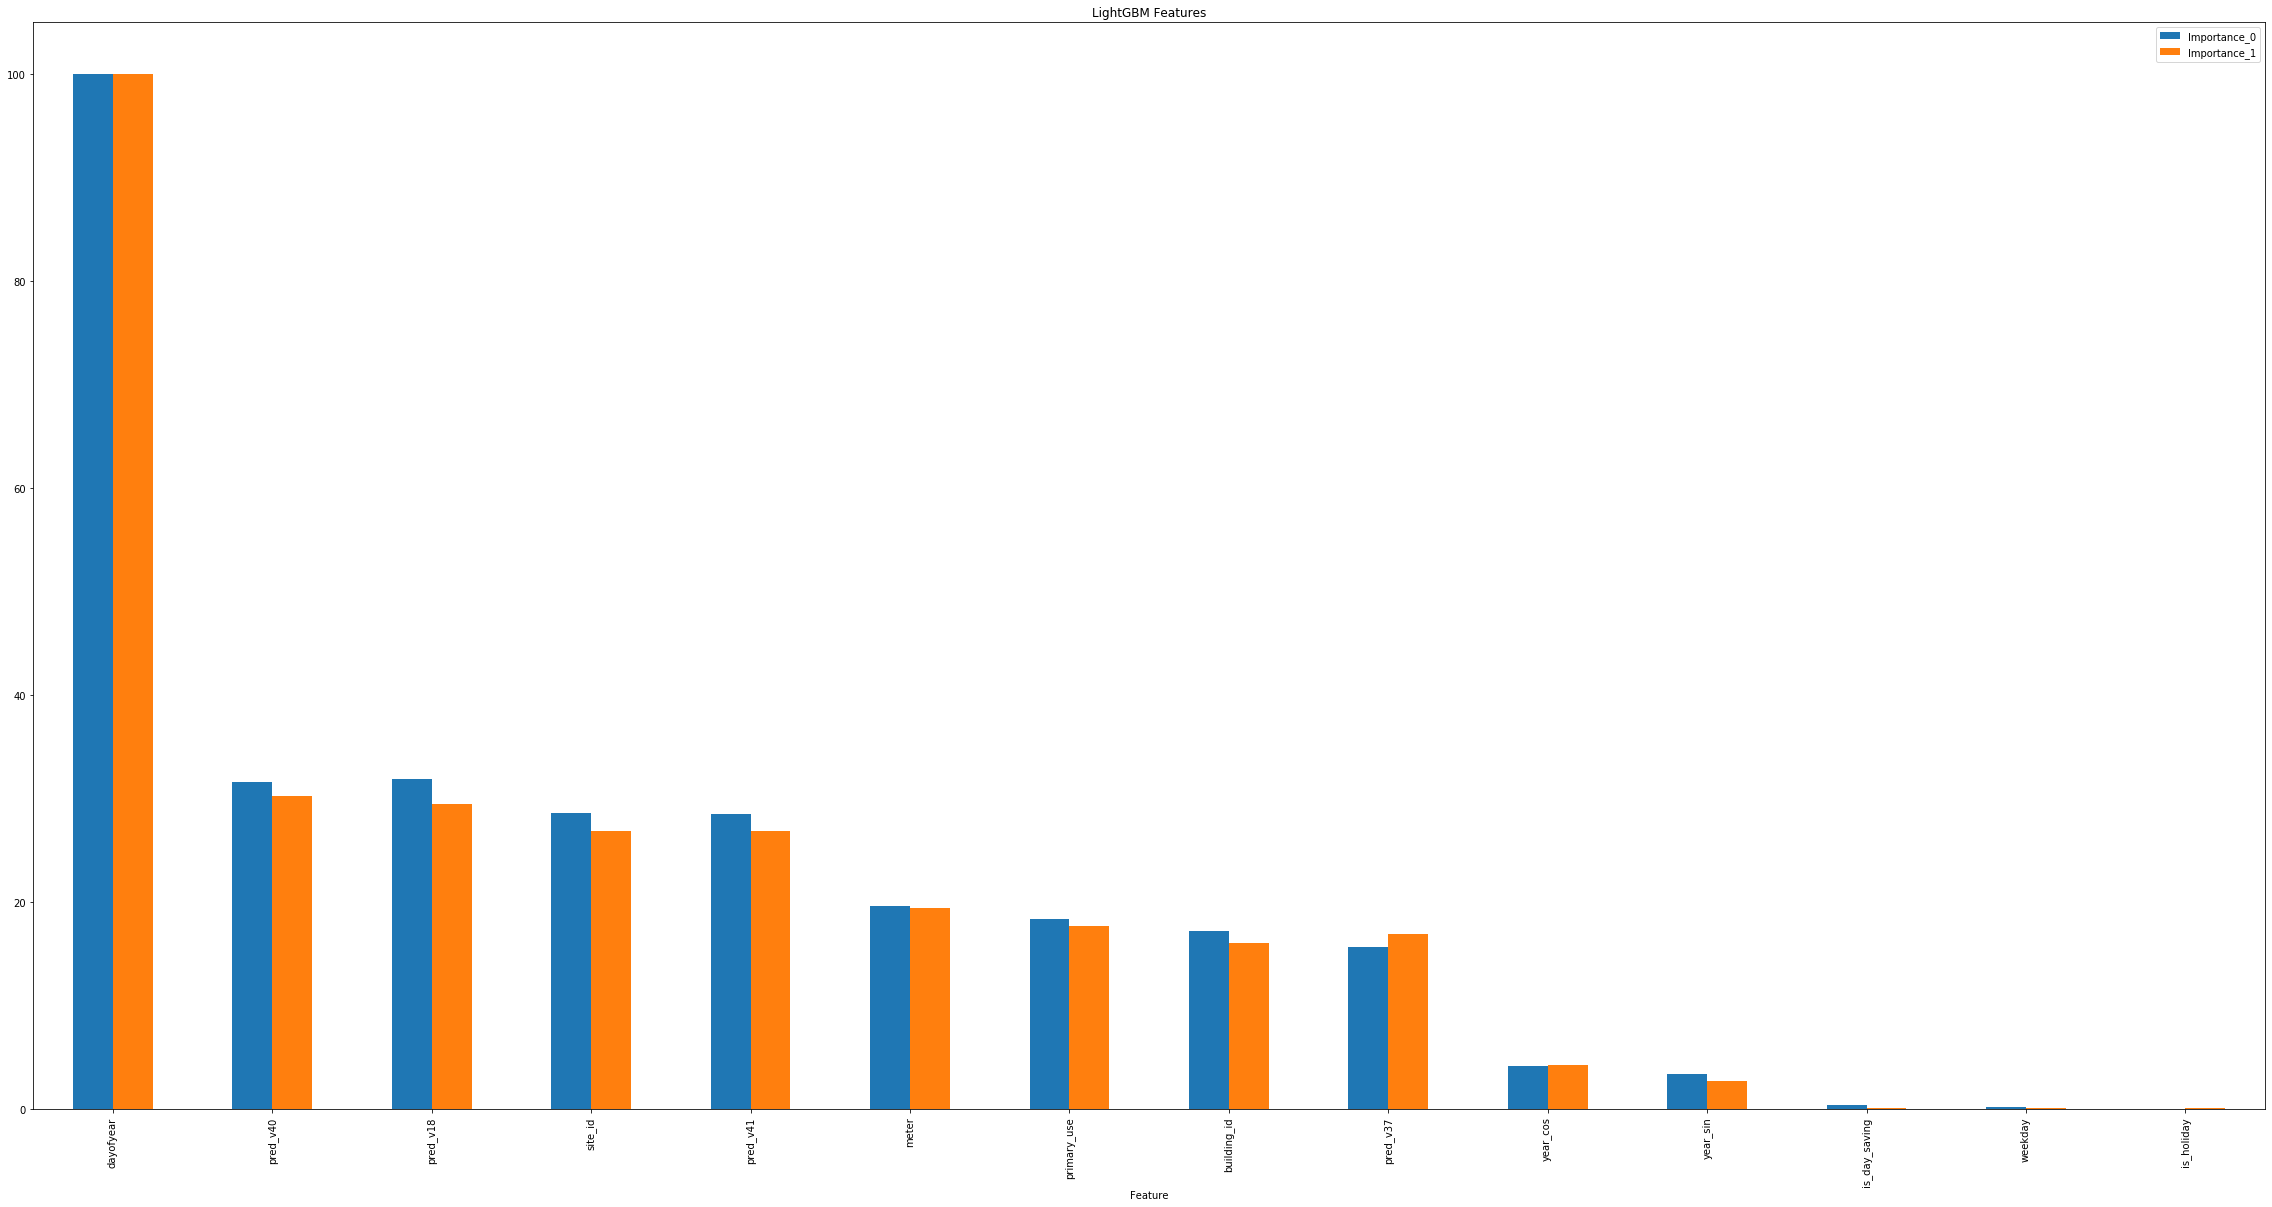

In [25]:
feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].plot(figsize=(40, 20), kind='bar')
plt.title('LightGBM Features')
plt.show()

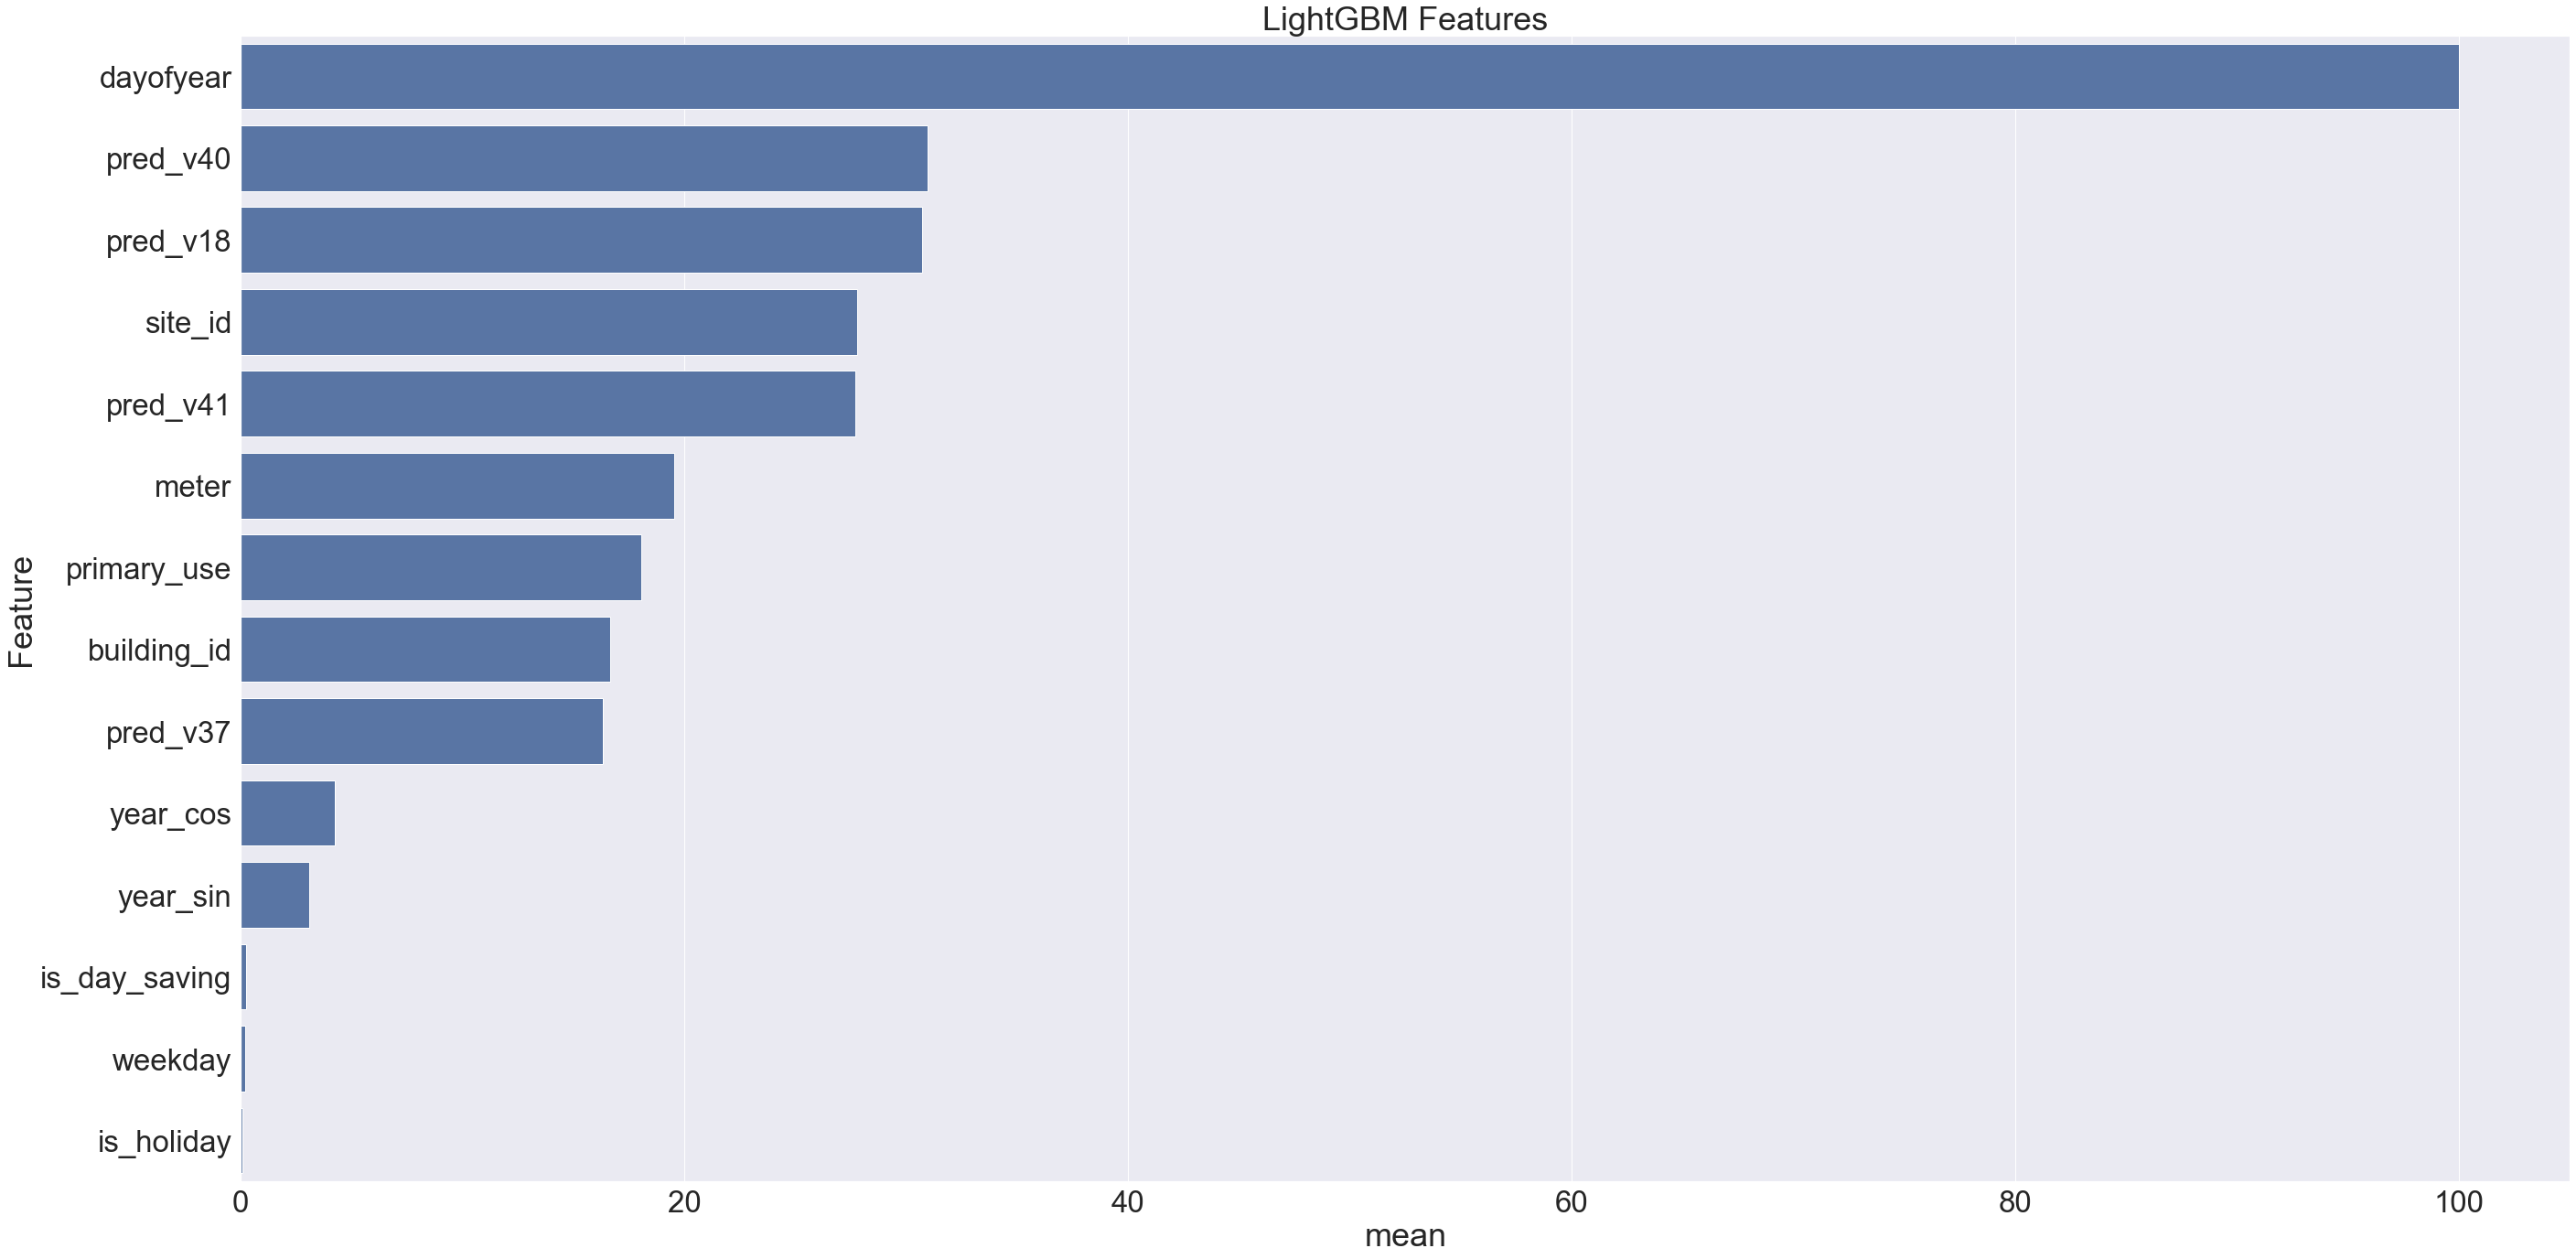

In [26]:
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="mean", y="Feature", data=feature_imp.sort_values(by="mean", 
                                                    ascending=False).reset_index(), color='C0')

plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [27]:
feature_imp.to_csv(f'./models/feature_importance_{version}.csv')

In [ ]:
feature_imp.tail(20)

# Retrain with all data

In [ ]:
tr_data = lgb.Dataset(train[features],label=train[target])

gc.collect()
estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data],
            verbose_eval = 50)

model_filename = 'models/' + model_name + '_v_' + str(version) + '_fold_all.bin'
pickle.dump(estimator, open(model_filename, 'wb'))

del train, tr_data
gc.collect()